<a href="https://colab.research.google.com/github/zmess24/personal-website-nextjs/blob/main/vector_dbs_and_cosine_similarity_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome back, everyone! Today's topic will hopefully be a fun one, as we will be venturing deeper into the world of Natural Language Processing (NLP) by exploring an exciting topic at the heart of most generative AI applications - vector databases! Vector databases, though not a novel technology, have gained immense popularity over the last few years as a key component of Retrieval Augmented Generation (RAG) - a technique that's revolutionized how we address the challenges of hallucinations and inaccuracies in Large Language Models (LLMs). If you're reading this, my guess is that you have most likely heard of these terms before.

The goal for today's post will be to create a naive implemententation of a vector database from scratch, while incorporating some key features and functionality from a performance perspective. And at the end, we'll go through an example of how to use our "scratch" vector database to perform a similarity search on a list of recipes provided a given query.

Withour further adu, let's get right into it!

### What is a Vector Database?

In my [previous post](https://www.zacmessinger.com/posts/intro-to-word-embeddings-with-word2vec), we delved into a crucial aspect of modern natural language processing by examining word embeddings, which are dense vectors of floating-point values that can be used to capture context and semantic relationships of words, and by extension, sentences. Embeddings are a undoubtly a powerful tool, but, thats all they are - a tool. The real value comes in how we use them in the context of more powerful models and applications, which is where vector databases come into play!

A vector database is a specialized type of database designed to store and manage high-dimensional vectors. Unlike traditional databases that handle structured data, such as numbers and strings, a vector database has the ability to handle complex datatypes like text and images by storing them in vector space as embeddings. The core advantage of a vector database lies in its ability to perform rapid and scalable similarity searches across vast datasets, which is crucial for applications such as recommendation systems, image and video retrieval, and more.

With an understanding of what a vector database is and what it is used for, let's move into the code centric portion of this post!

### Library Import

Let's kick everything off by downloading & importing in the libraries we'll use throughout the remainder of this post. There are two new NLP specific libraries here today, so I've included a short description of what they do for reference as we progress through the sections to come.

*   [SentenceTransformer](https://www.sbert.net/): A Python module for accessing, using, and training state-of-the-art text and image embedding models that is maintained by HuggingFace.
*   [nltk](https://www.nltk.org/): nltk (aka Natural Language Toolkit) is a popular API that provides a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning.



In [1]:
# Path & Serialization Libraries
import os
import requests

# Data & Visualization Libraries
import numpy as np
import pandas as pd
import json
import  matplotlib.pyplot as plt

# Text Preprocessing
import nltk
import re
import string

# Embedding Model
try:
  from sentence_transformers import SentenceTransformer
except:
  !pip install sentence-transformers -q
  from sentence_transformers import SentenceTransformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Downloading a Dataset

There's not much work to be done without a robust dataset to fuel our project (or in this case our vector database), so let's import one. Given the goal we're working towards is to leverage a vector database to run searches on food recipes most similar to user provided queries, this obviously means we'll need a dataset of recipes to work with. Luckily for us, I've gone ahead and curated a dataset of roughly ~1900 recipes by scraping www.bodybuilding.com.

We don't need to do anything fancy here - we'll simply fetch the dataset URL from Github, download the file text, and convert it to JSON before storing the output in a pandas dataframe.

In [ ]:
# URL of our JSON file
url = "https://github.com/zmess24/AI_Resources/raw/main/datasets/recipes.json"

# Fetch the url file and convert the text in the file to JSON
response = requests.get(url)
data = json.loads(response.text)

# Create a dataframe from the JSON data
df = pd.DataFrame(data)
df.head()

,title,author,description,calories,carbs,proteins,fats,ingrediants,directions,image_link
0,Beef Teriyaki Rice and Stir Fry,Contributing Writer,Our highest-quality Hawaiian teriyaki beef is ...,352,38,40,5,"[1 serving Hawaiian teriyaki beef, ½ cup brown...","[Prepare rice to your specifications., Chop br...",https://www.bodybuilding.com/images/2023/octob...
1,Chicken Teriyaki Rice and Broccoli,Contributing Writer,Our Hawaiian teriyaki chicken is tender glazed...,391,43,34,9,"[1 serving Hawaiian Teriyaki Chicken, 1 servin...","[Prepare rice to your specifications., Chop br...",https://www.bodybuilding.com/images/2023/octob...
2,Braised Pork with Soy Rice and Coleslaw,Contributing Writer,Our slow-cooked pork shoulder encompasses the ...,529,43,33,25,"[1 serving kalua pork, 1 serving kalua marinad...",[Prepare rice to your specifications and add s...,https://www.bodybuilding.com/images/2023/octob...
3,"Buffalo Chicken Thigh, Mashed Potatoes, and As...",Contributing Writer,"The freshest ingredients, including garlic, cu...",266,17,40,4,"[1 serving Buffalo chicken, 1 serving Buffalo ...",[Prepare potatoes and boil until soft and mash...,https://www.bodybuilding.com/images/2023/octob...
4,"Pollo Asado, Corn Salsa, and Cilantro Lime Rice",Contributing Writer,Our pollo asado is marinated in the best flavo...,427,45,36,12,"[1 serving pollo Asado, 1 serving asado Marina...","[Prepare rice to your specifications., Add lim...",https://www.bodybuilding.com/images/2023/octob...


### Generating Embeddings

Now that we have a recipe dataset ready to rock and roll, the next step is transforming each recipe into an embedding that accurately captures the semantic meaning of each recipe in vector form. Looking at the columns of our dataset from above, we have a few different options to play around with for determining what combination of attributes would best represent the semantic meaning of each recipe. For example, would we want to include amount of carbs, protiens and fats in the embedding? What about the recipe author?

Choosing what to include in each embedding is an important thought exercise, and requires a nuanced understanding of how we imagine our vector database would be used by our application. In practice, we might run A/B tests on different combinations of attributes to see which combinations yield the highest precision against a test set of queries. However, we're going to keep things simple here and construct our embeddings using a combination of a recipe's title and description, while storing the rest of the attributes in a metadata storage system. More on that aspect in bit.

We'll create our embeddings using a two step process; first, we will use pandas to combine the `title` and `description` strings into a new feature we'll call `title_description`, before converting those new features into a list. Second, we'll pass in that list to the `SentenceTransformer` embedding model to convert each feature string into an embedding. While this might sound like a lot, it actually only takes 4 lines of code to achieve.

In [ ]:
# Santize description column string
df['description'] = df['description'].str.replace('\n', '', regex=False)

# Combine title and description
df['title_description'] = df['title'] + ": " + df['description']
recipes = df['title_description'].tolist()

# Initialize Sentence Transformer model and encode recipes
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(recipes)

# Print Output
print(f"Total Recipes: {len(recipes)}")
print(f"Total Embeddings: {len(embeddings)}")
print(f"Embedding Dimensions: {embeddings[0].shape[0]}")

Total Recipes: 1716
Total Embeddings: 1716
Embedding Dimensions: 384


We can see that the ouput of the above code has resulted in generating an embedding for every recipe in our dataset, with each embedding having 384 dimensions.

If you're wondering why 384 is the magic number, it's just because that's what the specific pretrained model we're using ([all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)) was optimized for. Different embedding models will produce vectors of different dimensions and quality; for example, the default number of output dimensions for [OpenAI's](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings) `text-embedding-3-small` embedding model is 1536, while the `text-embedding-3-large` model has a default of 3072 dimensions. Compared to those models, 384 might seem like a low number, but the trade-off is that increasing the number of dimensions will also increase our storage, memory, and computation costs. Given our naive implementation and low requirements, `all-MiniLM-L6-v2`  strikes a good balance between capturing sufficient information and being computationally feasible, while still being production grade.

### Vector Database Requirements Overview

Now let's get to the exciting part of this post: how our vector database will work with these embeddings. Database design is a subject matter onto itself that can get complex quickly, but the key concept to grap is that any persistant storage system's functionality will largely revolve around what are known as the "CRUD" operations of create, read, update, and delete. Given our simple implementation and use case, we're only going to include on the first two operations (create and read), while additionally including some features optimized for working specifically with embeddings.

Below is the full list of features we'll going to create:

* **Query Sanitization**: We'll sanitize input text to normalize and enhance its semantic meaning. This will also facilitate efficient storage of embeddings in the cache.
* **Caching**: We'll implement a Least Recently Used (LRU) cache to store recently searched query embeddings in memory, reducing computational load and potential costs associated with running the embedding model.
* **Search Method**: We'll develop a method to return the top 5 most similar embeddings, along with their associated metadata, based on the input query

We'll tackle these in order, starting with query sanitization!

### Query Sanitization

Query sanitization is a handy technique in NLP applications that helps boost performance by first "cleaning up" an input string before converting it into an embedding. This step is useful for a bunch of reasons:

* **Consistency**: Ensures that input queries are consistent with the data stored in the vector database. This consistency can lead to more accurate and relevant search results.
* **Security**: Helps prevent injection attacks or other malicious inputs that could compromise the security of the database or the application using it. This is particularly important for web applications that accept user inputs.
* **Performance Optimization**: Removes unnecessary characters and normalizes the input, which can reduce the complexity of processing queries and improve the performance of the database.
* **Improved Search Accuracy**: Enhances the semantic integrity of the query, leading to better matching and retrieval. For instance, removing stop words and performing stemming or lemmatization can make the query more effective.

For our scratch database, we won't be performing any complex preprocessing steps. Instead, we'll focus on three main tasks: removing special characters, normalizing the text by converting it to lowercase, and removing stopwords. In case you're unfamiliar with “stopwords”, they are common words that occur frequently in a language but typically don't carry significant meaning. Examples of stopwords include “is,” “in,” “and,” “the,” “a,” and so on.

Let's get started by using the `nltk` library to download a list of english stopwords, You can view view full the list of words included [here](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/).

In [ ]:
# Download NLTK stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Next, let's write a simple function that handles the three sanitization tasks we mentioned above:

In [ ]:
def sanitize_query(query: string):
  # Lowercase text
  lowercased = query.lower()
  # Remove punctuation
  text = re.sub(f'[{re.escape(string.punctuation)}]', '', lowercased)
  # Tokenize and remove stopwords
  text = [token for token in text.split() if token not in stop_words]
  return " ".join(text)

input = "Asian healthy chicken and rice recipes!!!!"
sanitize_query(input)

'asian healthy chicken rice recipes'

### Creating a Least Recently Used (LRU) Cache


Next, let's implement a low-effort caching system for storing already generated query embeddings. While the `SentenceTransformer` model we're using is open-source and doesn't cost money to run, there are still performance gains to be considered by not having to generate every user query from scratch. Additionally, if we ever decide to swap out our current embedding model for a state-of-the-art one (like OpenAI or VoyageAI) where we might need to pay for token consumption, having a caching system is one way to implement cost-saving guardrails.

There are many different caching systems to choose from, but given our goal of trying to reduce the number of queries we run through our embedding model, focusing on caching the most frequently occurring queries seems like a good approach. Enter a Least Recently Used (or LRU) cache! An LRU cache works exactly as it sounds, by removing the least recently used key-value pairs from memory, which ensures that only the most frequent queries remain in the cache.

The actual implementation is straightforward. Every time a user runs a new query through our database, we will first check the LRU cache. If the key exists (after running query sanitization), we will return the associated embedding and then bump the key to the end of the cache (which represents the "safe" zone). If the key doesn't exist, we will store the query and its embedding in the cache, and then remove the key-value pair at the front of the cache if the length of the cache exceeds our specified limit.

In [ ]:
from collections import OrderedDict
from typing import List

class LRUCache:
  def __init__(self, capacity: int):
    self.cache = OrderedDict()
    self.capacity = capacity

  def get(self, key: str) -> int:
    # If they key doesn't exist in the cache, return
    if key not in self.cache: return None
    # Move accessed key to the end & return value
    self.cache.move_to_end(key)
    return self.cache[key]

  def put(self, key: str, value: List[float]) -> None:
    # If key is in cache, update
    if key in self.cache: self.cache.move_to_end(key)
    # Create key/value pair in cache
    self.cache[key] = value
    if len(self.cache) > self.capacity:
      # Pop the first item from the ordered dict (the least recently used)
      self.cache.popitem(last=False)

In order to see the performance gains of leveraging an LRU cache in action, let's use a decorator function to measure the speed improvements of retrieving an embedding from memory versus generating it from scratch. Let's start by defining a simple time decorator function:

In [ ]:
# Import time modele
import time

# Define a decorator function to measure execution time of a function
def time_decorator(func):
  # Define a wrapper function to add the timing functionality
  def wrapper(*args, **kwargs):
    # Record the start time
    start_time = time.time()
    # Execute the function with its arguments and keyword arguments
    result = func(*args, **kwargs)
    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    # Print the function name and the elapsed time
    print(f"Function '{func.__name__}' executed in {elapsed_time:.4f} seconds")
    # Return the result of the function
    return result

  # Return the wrapper function
  return wrapper

And next, let's create an instance of our LRU cache, and measure the execution time of our new `generate_embedding` function.

In [ ]:
# Init a new instance of an LRU cache
cache = LRUCache(capacity=100)

@time_decorator
def generate_embedding(query: string):
  # Sanitize input
  sanitized = sanitize_query(query)
  # Generate embedding and update cache
  embedding = cache.get(sanitized) if cache.get(sanitized) is not None else model.encode(sanitized)
  cache.put(sanitized, embedding)
  # Return Embedding
  return embedding

# Example usage
embedding = generate_embedding("High protein and healthy snacks")
embedding = generate_embedding("High protein and healthy snacks")

Function 'generate_embedding' executed in 0.0362 seconds
Function 'generate_embedding' executed in 0.0000 seconds


Wow! In additon to any cost savings gained by not having to run the embedding model each time, retrieving an embedding from cache was about ~362 times faster than generating it from scratch! At scale, this would be an immensely helpful performance optimization if we were potentially processing thousands of concurrent requests.

### Search Method

Last but not least, the final and most exciting feature in our vector database will be the implementation of a search function that returns the most similar embeddings to a user-provided query. To achieve this, we will utilize the linear algebra concept of cosine similarity, which I briefly covered a few months ago in my post “[Intro to NLP with TF-IDF Vectorization](https://www.zacmessinger.com/posts/intro-to-nlp-with-tfidf).” This time, however, we will delve into greater depth.

Cosine similarity, in simple terms, measures how similar two vectors are by looking at the angle between them. If the angle is small, then we would generally say that the vectors are similar, where if the angle is large, we would say that they are dissimlar. The easiest way to grasp this concept is visually, so let's plot three basic vectors with a little help from the handy `matplotlib` library:

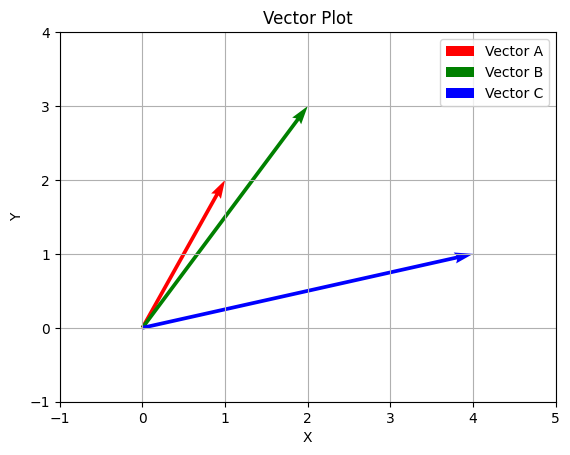

In [ ]:
# Define the vectors
vector_a = np.array([1, 2, 3])
vector_b = np.array([2, 3, 4])
vector_c = np.array([4, 1, 0])

# Plot the vectors
plt.figure()

# Plot vectors
plt.quiver(0, 0, vector_a[0], vector_a[1], angles='xy', scale_units='xy', scale=1, color='r', label='Vector A')
plt.quiver(0, 0, vector_b[0], vector_b[1], angles='xy', scale_units='xy', scale=1, color='g', label='Vector B')
plt.quiver(0, 0, vector_c[0], vector_c[1], angles='xy', scale_units='xy', scale=1, color='b', label='Vector C')

# Setting the plot limits
plt.xlim(-1, 5)
plt.ylim(-1, 4)

# Add titles and labels
plt.title('Vector Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Display the plot
plt.grid()
plt.show()

It's very easy to see the vectors A and B are much more similar than vectors B and C, because they are pointing in nearly identical directions. But the trick is, how can we represent these relationships mathmatically given that we could potentially be comparing thousands of vectors, or more, at once? Enter cosine simialrity, otherwise known as the [Euclidean Dot Product](https://en.wikipedia.org/wiki/Cosine_similarity) formula.

Let's layout the formula in it's entirety and then walk through a practical example of how to apply it.

$$
 \text{cosine similarity} = S_C(A, B) := \cos(\theta) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \cdot \sqrt{\sum_{i=1}^{n} B_i^2}}
$$

To break it down into layman's terms:

* We calculate the dot product of vector $A$ and vector $B$, represented by the formula ${\sum_{i=1}^{n} A_i B_i}$. If you want to learn more about dot product multiplication, check out my [Fun with Linear Algebra and Matrices
](https://www.zacmessinger.com/posts/fun-with-linear-algebra-and-matrices) post.
* We determine the product of their magnitudes by applying the Euclidean norm, which is a fancy way of saying we take the square root of the sum of the squares of each vector's componenets. The Euclidean norm is represented by the formula ${\sqrt{\sum_{i=1}^{n} A_i^2} \cdot \sqrt{\sum_{i=1}^{n} B_i^2}}$.
* We then calculate the cosine similarity by dividing the dot product of the vectors by the product of their magnitudes.

This math might sound intimidating, but it's simplier than it looks. Let's go through an example together using the two vectors below:

$$
\mathbf{a} = \begin{bmatrix} 1 \\ 2 \\ 3 \end{bmatrix}, \quad
\mathbf{b} = \begin{bmatrix} 2 \\ 3 \\ 4 \end{bmatrix}, \quad
$$

First, we calculate the dot product of the vectors.

$$
\mathbf{A} \cdot \mathbf{B} = (1 \cdot 2) + (2 \cdot 3) + (3 \cdot 4) = 2 + 6 + 12 = 20
$$

Next, we determine the magnitude of each vector.

$$
\|\mathbf{A}\| = \sqrt{1^2 + 2^2 + 3^2} = \sqrt{1 + 4 + 9} = \sqrt{14} \\
\|\mathbf{B}\| = \sqrt{2^2 + 3^2 + 4^2} = \sqrt{4 + 9 + 16} = \sqrt{29} \\
$$


Finally, we divide the dot product by the product of the vectors’ magnitudes.

$$
\|\mathbf{A}\| * \|\mathbf{B}\| = \sqrt{14} \cdot \sqrt{29} = \sqrt{14 \times 29} = \sqrt{406} \\
\|\mathbf{A}\| * \|\mathbf{B}\| = \sqrt{406} \approx 20.1494 \\
\cos(\theta) = \frac{20}{20.1494} \approx 0.9925
$$

Converting this formula into Python is extremely easy using python's `numpy` library, which provides support for working with large, multi-dimensional arrays and matrices along with a large collection of high-level mathematical functions to operate on these arrays.

In [ ]:
def cosine_similarity(vector_a, vector_b):
  # Ensure the vectors are numpy arrays
  vector_a = np.array(vector_a)
  vector_b = np.array(vector_b)
  # Calculate the dot product
  dot_product = np.dot(vector_a, vector_b)
  # Calculate the magnitudes of the vectors
  magnitude_a = np.linalg.norm(vector_a)
  magnitude_b = np.linalg.norm(vector_b)
  # Calculate the cosine similarity
  cosine_sim = dot_product / (magnitude_a * magnitude_b)
  return cosine_sim

# Example usage
vector_a = [1, 2, 3]
vector_b = [2, 3, 4]
cosine_similarity(vector_a, vector_b)

0.9925833339709303

In case you're wondering whether 0.9925 is a good or bad score, it's important to understand the range and meaning of cosine similarity values. The cosine similarity formula produces a score between -1 and 1. A score of 1 indicates that the compared vectors point in exactly the same direction, and conversely, a score of -1 indicates that the items are diametrically opposed, meaning they point in exactly opposite directions. A score of 0 indicates that the vectors are orthogonal, or at a 90-degree angle to each other, signifying no directional similarity.

To put this into perspective, here's a plot comparing vectors that are identical (0-degree angle), orthogonal (90-degree angle), and in opposite directions, along with their cosine similarity scores:

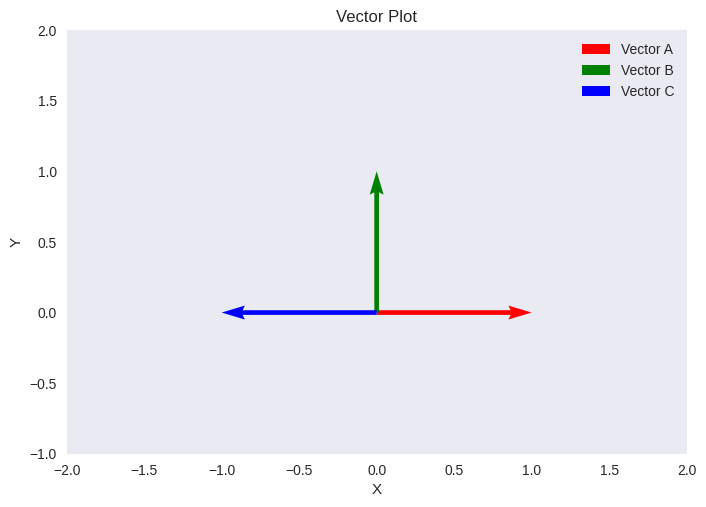

Cosine similarity between vector_a and vector_a (orthogonal): 1.0
Cosine similarity between vector_a and vector_b (orthogonal): 0.0
Cosine similarity between vector_a and vector_c (opposite direction): -1.0


In [ ]:
# Define example vectors
vector_a = [1, 0]
vector_b = [0, 1]
vector_c = [-1, 0]

# Create plot
plt.figure()

# Plot each vector
plt.quiver(0, 0, vector_a[0], vector_a[1], angles='xy', scale_units='xy', scale=1, color='r', label='Vector A')
plt.quiver(0, 0, vector_b[0], vector_b[1], angles='xy', scale_units='xy', scale=1, color='g', label='Vector B')
plt.quiver(0, 0, vector_c[0], vector_c[1], angles='xy', scale_units='xy', scale=1, color='b', label='Vector C')

# Setting the plot limits
plt.xlim(-2, 2)
plt.ylim(-1, 2)

# Add titles and labels
plt.title('Vector Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Display the plot
plt.grid()
plt.show()

# Calculate cosine similarities
similarity_a_a = cosine_similarity(vector_a, vector_a)  # Orthogonal
similarity_a_b = cosine_similarity(vector_a, vector_b)  # Orthogonal
similarity_a_c = cosine_similarity(vector_a, vector_c)  # Opposite direction

print(f'Cosine similarity between vector_a and vector_a (orthogonal): {similarity_a_a}')
print(f'Cosine similarity between vector_a and vector_b (orthogonal): {similarity_a_b}')
print(f'Cosine similarity between vector_a and vector_c (opposite direction): {similarity_a_c}')

In this context, a cosine similarity score of 0.9925 suggests that the vectors are highly similar and almost align perfectly with each other! If we re-examine our previously created vector plot, we can see that the angle between vectors $A$ and $B$ is extremely small, signifying that the vectors are nearly parallel and thus confirming their high similarity.

To add support for cosine similarity in our vector database, we need to modify our existing `cosine_similarity` function to compare a single query vector against our database of stored embedding vectors. We can achieve this by nesting the formula inside a loop and returning the similarity scores for each vector pairing in a list.

In [ ]:
def cosine_similarity(query_vector, vectors):
  similarities = []

  for vector in vectors:
    # Ensure the vectors are numpy arrays
    vector_a = np.array(vector)
    vector_b = np.array(query_vector)
    # Calculate the dot product
    dot_product = np.dot(vector_a, vector_b)
    # Calculate the magnitudes of the vectors
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)
    # Calculate the cosine similarity
    cosine_sim = dot_product / (magnitude_a * magnitude_b)
    similarities.append(round(cosine_sim, 8))

  return similarities

# Example usage
vector_a = [1, 2, 3]
vectors = [[2, 3, 4], [4, 1, 0]]
cosine_similarity(vector_a, vectors)

[0.99258333, 0.38892223]

And for validation, let's test our implementation against a production grade function from [scikit-learn](https://scikit-learn.org/), and see how our custom solution compares:

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([vector_a], vectors)[0]

array([0.99258333, 0.38892223])

Not bad! As a final step, let's combine all our previous logic into a single `search` function. This function will take a query, generate an embedding if it doesn't exist in the cache, measure the cosine similarities between the query embedding and the database of embeddings, and finally return the top 5 results closest to a score of 1, in descending order.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def search(query: str, k=5):
  # Generate embedding
  embedding = generate_embedding(query)
  # Calculate cosine similarity
  similarities = cosine_similarity([embedding], embeddings)[0]
  # Find the indices of the top-k most similar documents
  top_k_indices = similarities.argsort()[-k:][::-1]
  # Print the most similar documents
  print("Top-k similar documents:")
  for idx in top_k_indices:
      print(f"Document: {recipes[idx][:50]}... (Similarity: {similarities[idx]:.4f})")
  return top_k_indices

search("Protein shakes for breakfast!")

Function 'generate_embedding' executed in 0.0003 seconds
Top-k similar documents:
Document: Protein Scramble: Breakfast is the most important ... (Similarity: 0.7110)
Document: Protein Powder And Oatmeal: Instead of resorting t... (Similarity: 0.7099)
Document: Morning Breakfast Shake: Need a powerful morning p... (Similarity: 0.6774)
Document: Recipe: A Classic Protein Shake: Easy protein shak... (Similarity: 0.6636)
Document: Banana Almond Cream Shake: You don't have to eat m... (Similarity: 0.6557)


array([ 801, 1169, 1114,   31,  311])

### Putting It All Together

With all of our individual features fully implemented, the final step is to combine them into a single VectorDatabase class. While most class methods will be similar to what we've previously defined, there are a few key properties worth highlighting. These class properties are straightforward but crucial for the functionality and extendibility of the model:

* `model`: This property will hold the model used for generating embeddings.
* `dimensions`: This property represents the number of dimensions in each embedding. Although we don’t directly leverage it in our current implementation, it can be useful for validation purposes if we need to add new embeddings.
* `vectors`: This property stores the actual embeddings.
* `metadata`: This property contains any associated metadata for the embeddings.
* `cache`: This property is used to store embeddings that have been previously computed, enhancing the efficiency of the search function.

By consolidating all these components, our VectorDatabase class will provide a robust and efficient framework for handling vector-based queries and operations.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict, List

class VectorDatabase:
  def __init__(self, dimensions: int, capacity: int = 100):
    self.model = SentenceTransformer('all-MiniLM-L6-v2')
    self.dimensions = dimensions
    self.vectors = []
    self.metadata = []
    self.cache = LRUCache(capacity=100)

  def initialize(self, embeddings: List[float], metadata: List[str]):
    self.vectors = embeddings
    self.metadata = metadata

  def sanitize_query(self, query: string):
    # Lowercase text
    lowercased = query.lower()
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', lowercased)
    # Tokenize and remove stopwords
    text = [token for token in text.split() if token not in stop_words]
    return " ".join(text)

  def generate_embedding(self, query: string):
    # Sanitize input
    sanitized = self.sanitize_query(query)
    # Generate embedding and update cache
    embedding = cache.get(sanitized) if cache.get(sanitized) is not None else model.encode(sanitized)
    cache.put(sanitized, embedding)
    # Return Embedding
    return embedding

  def search(self, query: str, k=5):
    # Generate embedding
    embedding = self.generate_embedding(query)
    # Calculate cosine similarity
    similarities = cosine_similarity([embedding], embeddings)[0]
    # Find the indices of the top-k most similar documents
    top_k_indices = similarities.argsort()[-k:][::-1]
    return [self.metadata[idx] for idx in top_k_indices]

To test our implementation, let’s instantiate a copy of our database, initializing it with our pre-generated embeddings and downloaded recipe data, which will be stored as metadata.


In [ ]:
# Craete and initialize database
db = VectorDatabase(dimensions=384)
db.initialize(embeddings=embeddings, metadata=data)

Finally, let's attempt to search our database by seeing what the top 5 results are for the query, "Buffalo Chicken"!

In [ ]:
# Search stored data for
results = db.search('Buffalo Chicken')

# Print out results
for i, result in enumerate(results):
  print(f"{i+1}: {result['title']}: {result['description'][:50]}...")

1: Buffalo Chicken Dip: Enjoy with your favorite keto-friendly veggie for ...
2: Buffalo Chicken Thigh, Mashed Potatoes, and Asparagus: The freshest ingredients, including garlic, cumin,...
3: Pro JYM Boneless Buffalo Wings: Come on, you know you're looking for something new...
4: Skinny Buffalo Chicken Dip: Everyone's favorite dip goes a bit "lighter" with ...
5: Chicken Burger Topped With Feta, Roasted Red Bell Pepper & Arugula: Chicken is a great source of lean, high-quality pr...


### Conclusion

If you've made it this far, thank you for taking the time to read my post! I hope you learned a little bit about the usefulness of vector databases while gaining an appreciation for the mathmatics that powers similarity searches in modern NLP applications. In my next post, we are going to expand on some of concepts we covered here by diving into Retrieval Augmented Generation (known as RAG), which is one of the core applications of LLM and vector databases.

I'll catch you next time!